# Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import random
import warnings
from scipy import stats
import json
import pickle
import requests
from datetime import datetime, timedelta

# Configure environment

In [ ]:
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

# CONFIGURATION

In [ ]:
print("CONFIGURATION SETTINGS")

CONFIGURATION SETTINGS


## API Configuration

In [ ]:
API_BASE_URL = "https://le3tvo1cgc.execute-api.us-east-1.amazonaws.com/prod/get-data"
DEVICE_TABLES = ["device5", "device6", "device7", "device8"]  # Add/modify devices as needed

print(f"\n API Configuration:")
print(f"   Endpoint: {API_BASE_URL}")
print(f"   Devices: {', '.join(DEVICE_TABLES)}")



 API Configuration:
   Endpoint: https://le3tvo1cgc.execute-api.us-east-1.amazonaws.com/prod/get-data
   Devices: device5, device6, device7, device8


## Random Seed (for reproducibility)

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print(f"\n Random Seed: {RANDOM_SEED} (for reproducibility)")


 Random Seed: 42 (for reproducibility)


 ## Model Hyperparameters

In [ ]:
CONTAMINATION = 0.05          # Expected proportion of outliers (5%)
EPOCHS = 150                  # Maximum training epochs
BATCH_SIZE = 32               # Batch size for training
LEARNING_RATE = 1e-3          # Learning rate for Adam optimizer
DROPOUT_RATE = 0.25           # Dropout rate for regularization
L2_REG = 1e-5                 # L2 regularization factor

print(f"\n Model Hyperparameters:")
print(f"   Contamination: {CONTAMINATION}")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Dropout Rate: {DROPOUT_RATE}")
print(f"   L2 Regularization: {L2_REG}")


 Model Hyperparameters:
   Contamination: 0.05
   Epochs: 150
   Batch Size: 32
   Learning Rate: 0.001
   Dropout Rate: 0.25
   L2 Regularization: 1e-05


## Feature Engineering Parameters

In [ ]:
ROLL_WIN = 5                  # Rolling window size for statistical features
USE_ROBUST_SCALER = True      # Use RobustScaler (more resistant to outliers)

print(f"\n Feature Engineering:")
print(f"   Rolling Window: {ROLL_WIN} samples")
print(f"   Scaler: {'RobustScaler' if USE_ROBUST_SCALER else 'StandardScaler'}")


 Feature Engineering:
   Rolling Window: 5 samples
   Scaler: RobustScaler


## Anomaly Detection Parameters

In [ ]:
THRESHOLD_MULTIPLIER = 2.5
ENABLE_ENSEMBLE = True
MIN_ANOMALY_DURATION = 3

print(f"\n Anomaly Detection:")
print(f"   Threshold Multiplier: {THRESHOLD_MULTIPLIER}σ")
print(f"   Ensemble Detection: {ENABLE_ENSEMBLE}")
print(f"   Min Anomaly Duration: {MIN_ANOMALY_DURATION} samples")


 Anomaly Detection:
   Threshold Multiplier: 2.5σ
   Ensemble Detection: True
   Min Anomaly Duration: 3 samples


## Adaptive Threshold Configuration

In [ ]:
ENABLE_ADAPTIVE_THRESHOLDS = True
CURRENT_IQR_MULTIPLIER = 2.5
CURRENT_STD_MULTIPLIER = 3.0
CURRENT_PERCENTILE_LOW = 1
CURRENT_PERCENTILE_HIGH = 99
CURRENT_RATE_PERCENTILE = 95
RECENT_DATA_WINDOW_MINUTES = 20

print(f"\n Adaptive Thresholds:")
print(f"   IQR Multiplier: {CURRENT_IQR_MULTIPLIER}")
print(f"   Std Dev Multiplier: {CURRENT_STD_MULTIPLIER}")
print(f"   Percentile Range: [{CURRENT_PERCENTILE_LOW}, {CURRENT_PERCENTILE_HIGH}]")
print(f"   Rate Percentile: {CURRENT_RATE_PERCENTILE}")
print(f"   Recent Data Window: {RECENT_DATA_WINDOW_MINUTES} minutes")

OUT_DIR = "battery_ae_if_results"
MODEL_DIR = os.path.join(OUT_DIR, "models")
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"\n Output Configuration:")
print(f"   Output Directory: {OUT_DIR}")
print(f"   Model Directory: {MODEL_DIR}")



 Adaptive Thresholds:
   IQR Multiplier: 2.5
   Std Dev Multiplier: 3.0
   Percentile Range: [1, 99]
   Rate Percentile: 95
   Recent Data Window: 20 minutes

 Output Configuration:
   Output Directory: battery_ae_if_results
   Model Directory: battery_ae_if_results/models


# HELPER FUNCTIONS

## API Data Fetching

In [ ]:
def fetch_device_data(device_table):
    try:
        url = f"{API_BASE_URL}?table={device_table}"
        print(f"  Fetching from: {url}")

        response = requests.get(url, timeout=30)
        response.raise_for_status()

        data = response.json()

        if isinstance(data, list):
            df = pd.DataFrame(data)
            print(f"Fetched {len(df):,} records")
            return df
        else:
            print(f"Unexpected data format")
            return None

    except requests.exceptions.RequestException as e:
        print(f"API Error: {e}")
        return None
    except Exception as e:
        print(f"Error: {e}")
        return None


## Data Cleaning Functions

In [ ]:
def clean_numeric_series(s):
    return pd.to_numeric(
        s.astype(str).str.replace("'", "").str.replace(",", "").str.strip(),
        errors="coerce"
    )


## Outlier Detection

In [ ]:
def detect_outliers_zscore(series, threshold=3):
    z_scores = np.abs(stats.zscore(series, nan_policy='omit'))
    return z_scores > threshold


## Anomaly Smoothing

In [ ]:
def smooth_anomalies(anomaly_series, min_duration=3):
    smoothed = anomaly_series.copy()
    changes = np.diff(np.concatenate([[0], anomaly_series, [0]]))
    starts = np.where(changes == 1)[0]
    ends = np.where(changes == -1)[0]

    for start, end in zip(starts, ends):
        if end - start < min_duration:
            smoothed[start:end] = 0

    return smoothed

## Adaptive Threshold Calculation

In [ ]:
def calculate_adaptive_thresholds(data, column_name='current'):
    data_clean = data.dropna()

    # Method 1: IQR-based (robust to outliers)
    Q1 = np.percentile(data_clean, 25)
    Q3 = np.percentile(data_clean, 75)
    IQR = Q3 - Q1

    iqr_lower = Q1 - CURRENT_IQR_MULTIPLIER * IQR
    iqr_upper = Q3 + CURRENT_IQR_MULTIPLIER * IQR

    # Method 2: Mean ± Std
    mean_val = np.mean(data_clean)
    std_val = np.std(data_clean)
    std_lower = mean_val - CURRENT_STD_MULTIPLIER * std_val
    std_upper = mean_val + CURRENT_STD_MULTIPLIER * std_val

    # Method 3: Percentile-based
    percentile_lower = np.percentile(data_clean, CURRENT_PERCENTILE_LOW)
    percentile_upper = np.percentile(data_clean, CURRENT_PERCENTILE_HIGH)

    # Method 4: MAD (Median Absolute Deviation)
    median_val = np.median(data_clean)
    mad = np.median(np.abs(data_clean - median_val))
    mad_lower = median_val - 3 * 1.4826 * mad
    mad_upper = median_val + 3 * 1.4826 * mad

    # Combine methods - take most conservative bounds
    lower_threshold = min(iqr_lower, std_lower, mad_lower)
    upper_threshold = max(iqr_upper, std_upper, mad_upper)

    # Warning zones (less severe)
    warning_lower = np.percentile(data_clean, 5)
    warning_upper = np.percentile(data_clean, 95)

    # Rate of change threshold
    rate_data = np.abs(np.diff(data_clean))
    rate_threshold = np.percentile(rate_data, CURRENT_RATE_PERCENTILE)

    thresholds = {
        'lower_critical': lower_threshold,
        'lower_warning': warning_lower,
        'upper_warning': warning_upper,
        'upper_critical': upper_threshold,
        'rate_threshold': rate_threshold,
        'mean': mean_val,
        'median': median_val,
        'std': std_val,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR
    }

    return thresholds

## Current Anomaly Detection

In [ ]:
def detect_current_anomalies_adaptive(current, thresholds):
    anomalies = np.zeros(len(current), dtype=int)
    reasons = [''] * len(current)
    severity = ['normal'] * len(current)

    current_rate = np.abs(np.diff(current, prepend=current[0]))

    for i in range(len(current)):
        reason_parts = []
        current_severity = 'normal'

        # Zero current is normal (discharge/idle state)
        if current[i] == 0:
            pass

        # Check for excessive charge current
        elif current[i] > thresholds['upper_critical']:
            anomalies[i] = 1
            current_severity = 'critical'
            reason_parts.append(f"Excessive charge: {current[i]:.3f}A (threshold: {thresholds['upper_critical']:.3f}A)")
        elif current[i] > thresholds['upper_warning']:
            anomalies[i] = 1
            current_severity = 'high'
            reason_parts.append(f"High charge: {current[i]:.3f}A")

        # Check for unusually low non-zero current (potential issue)
        if 0 < current[i] < thresholds['lower_critical']:
            anomalies[i] = 1
            if current_severity == 'normal':
                current_severity = 'medium'
            reason_parts.append(f"Unusually low current: {current[i]:.3f}A (threshold: {thresholds['lower_critical']:.3f}A)")

        # Check rate of change
        if current_rate[i] > thresholds['rate_threshold']:
            anomalies[i] = 1
            if current_severity == 'normal':
                current_severity = 'medium'
            reason_parts.append(f"Rapid current change: {current_rate[i]:.3f}A/sample")

        reasons[i] = "; ".join(reason_parts)
        severity[i] = current_severity

    return anomalies, reasons, severity


## Temperature Anomaly Detection

In [ ]:
def detect_temperature_anomalies_adaptive(temperature, thresholds):
    anomalies = np.zeros(len(temperature), dtype=int)
    reasons = [''] * len(temperature)
    severity = ['normal'] * len(temperature)

    temp_rate = np.abs(np.diff(temperature, prepend=temperature[0]))

    for i in range(len(temperature)):
        reason_parts = []
        temp_severity = 'normal'

        # Check for high temperature
        if temperature[i] > thresholds['upper_critical']:
            anomalies[i] = 1
            temp_severity = 'critical'
            reason_parts.append(f"Critical high temp: {temperature[i]:.2f}°C (threshold: {thresholds['upper_critical']:.2f}°C)")
        elif temperature[i] > thresholds['upper_warning']:
            anomalies[i] = 1
            temp_severity = 'high'
            reason_parts.append(f"High temp: {temperature[i]:.2f}°C")

        # Check for low temperature
        if temperature[i] < thresholds['lower_critical']:
            anomalies[i] = 1
            temp_severity = 'critical' if temp_severity != 'critical' else temp_severity
            reason_parts.append(f"Critical low temp: {temperature[i]:.2f}°C (threshold: {thresholds['lower_critical']:.2f}°C)")
        elif temperature[i] < thresholds['lower_warning']:
            anomalies[i] = 1
            if temp_severity == 'normal':
                temp_severity = 'medium'
            reason_parts.append(f"Low temp: {temperature[i]:.2f}°C")

        # Check rate of change
        if temp_rate[i] > thresholds['rate_threshold']:
            anomalies[i] = 1
            if temp_severity == 'normal':
                temp_severity = 'medium'
            reason_parts.append(f"Rapid temp change: {temp_rate[i]:.2f}°C/sample")

        reasons[i] = "; ".join(reason_parts)
        severity[i] = temp_severity

    return anomalies, reasons, severity

print(" Helper functions defined")

 Helper functions defined


# DATA LOADING FROM API

In [ ]:
all_dfs = []
device_names = []

for device_table in DEVICE_TABLES:
    print(f"\n Fetching {device_table}...")
    df_temp = fetch_device_data(device_table)

    if df_temp is not None and len(df_temp) > 0:
        df_temp['device_id'] = device_table
        all_dfs.append(df_temp)
        device_names.append(device_table)
        print(f"  Columns: {list(df_temp.columns)}")

if not all_dfs:
    raise Exception("No data fetched from API. Please check the API endpoints.")

# Combine all device data
df = pd.concat(all_dfs, ignore_index=True)

print(f"\n{'='*80}")
print(f"✓ DATA FETCHING COMPLETE")
print(f"{'='*80}")
print(f"Total combined rows: {len(df):,}")
print(f"Devices: {', '.join(device_names)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")



 Fetching device5...
  Fetching from: https://le3tvo1cgc.execute-api.us-east-1.amazonaws.com/prod/get-data?table=device5
Fetched 4,756 records
  Columns: ['ts', 'datetime', 'current', 'temperature', 'device_id']

 Fetching device6...
  Fetching from: https://le3tvo1cgc.execute-api.us-east-1.amazonaws.com/prod/get-data?table=device6
Fetched 2,530 records
  Columns: ['ts', 'datetime', 'current', 'temperature', 'device_id']

 Fetching device7...
  Fetching from: https://le3tvo1cgc.execute-api.us-east-1.amazonaws.com/prod/get-data?table=device7
Fetched 2,957 records
  Columns: ['ts', 'datetime', 'current', 'temperature', 'device_id']

 Fetching device8...
  Fetching from: https://le3tvo1cgc.execute-api.us-east-1.amazonaws.com/prod/get-data?table=device8
Fetched 4,958 records
  Columns: ['ts', 'datetime', 'current', 'temperature', 'device_id']

✓ DATA FETCHING COMPLETE
Total combined rows: 15,201
Devices: device5, device6, device7, device8
Memory usage: 2.23 MB


# DATA CLEANING AND PREPROCESSING

## clean Numeric Columns

In [ ]:
print("\n Cleaning numeric columns...")
df['current'] = clean_numeric_series(df['current'])
df['temperature'] = clean_numeric_series(df['temperature'])
print(f"   Cleaned 'current' and 'temperature' columns")


 Cleaning numeric columns...
   Cleaned 'current' and 'temperature' columns


## Parse Datetime

In [ ]:
print("\n Parsing datetime...")
df['parsed_datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
print(f"Parsed datetime: {df['parsed_datetime'].notna().sum():,}/{len(df):,} valid")

# Convert timestamp to datetime if needed
if 'ts' in df.columns and df['parsed_datetime'].isna().all():
    df['parsed_datetime'] = pd.to_datetime(df['ts'], unit='s', errors='coerce')
    print(f"Converted timestamp to datetime")


 Parsing datetime...
Parsed datetime: 15,201/15,201 valid


## Sort Data

In [ ]:
df = df.sort_values(['device_id', 'parsed_datetime']).reset_index(drop=True)

##  Handle Missing Values

In [ ]:
print("\n Handling missing values...")
initial_len = len(df)
df = df.dropna(subset=['current']).reset_index(drop=True)
removed = initial_len - len(df)
if removed > 0:
    print(f"   Removed {removed:,} rows with missing current data")
else:
    print(f"  No missing current data")


 Handling missing values...
  No missing current data


## Handle Negative Currents

In [ ]:
print("\n Handling negative currents...")
negative_count = (df['current'] < 0).sum()
if negative_count > 0:
    print(f"  Found {negative_count:,} negative current values ({100*(df['current'] < 0).mean():.2f}%)")
    print(f"   Setting negative currents to 0 (discharge = 0)")
    df['current'] = df['current'].clip(lower=0)
    print(f"   All negative currents set to zero")
else:
    print(f"   No negative currents found")



 Handling negative currents...
  Found 4,235 negative current values (27.86%)
   Setting negative currents to 0 (discharge = 0)
   All negative currents set to zero


## Handle Temperature Issues

In [ ]:
# Fill missing temperatures
temp_missing = df['temperature'].isna().sum()
if temp_missing > 0:
    print(f"  Found {temp_missing:,} missing temperature values")
    temp_median = df['temperature'].median()
    df['temperature'].fillna(temp_median, inplace=True)
    print(f" Filled missing temperatures with median: {temp_median:.2f}°C")

# Remove extreme temperature outliers
temp_q1 = df['temperature'].quantile(0.01)
temp_q99 = df['temperature'].quantile(0.99)
temp_outliers = ((df['temperature'] < temp_q1) | (df['temperature'] > temp_q99)).sum()
if temp_outliers > 0:
    print(f"   Found {temp_outliers:,} extreme temperature outliers")
    df['temperature'] = df['temperature'].clip(lower=temp_q1, upper=temp_q99)
    print(f"    Clipped temperatures to range [{temp_q1:.2f}, {temp_q99:.2f}]°C")

print(f"DATA QUALITY REPORT (AFTER CLEANING)")


print(f"\n Current Statistics:")
print(f"   Range: [{df['current'].min():.4f}, {df['current'].max():.4f}] A")
print(f"   Mean: {df['current'].mean():.4f} A")
print(f"   Median: {df['current'].median():.4f} A")
print(f"   Zero values: {(df['current'] == 0).sum():,} ({100*(df['current'] == 0).mean():.2f}%)")

print(f"\n  Temperature Statistics:")
print(f"   Range: [{df['temperature'].min():.2f}, {df['temperature'].max():.2f}] °C")
print(f"   Mean: {df['temperature'].mean():.2f} °C")
print(f"   Median: {df['temperature'].median():.2f} °C")

print(f"\n Final data shape: {df.shape}")

   Found 203 extreme temperature outliers
    Clipped temperatures to range [48.89, 73.33]°C
DATA QUALITY REPORT (AFTER CLEANING)

 Current Statistics:
   Range: [0.0000, 862.1401] A
   Mean: 0.8338 A
   Median: 0.0922 A
   Zero values: 4,235 (27.86%)

  Temperature Statistics:
   Range: [48.89, 73.33] °C
   Mean: 55.65 °C
   Median: 53.33 °C

 Final data shape: (15201, 6)


# ADAPTIVE THRESHOLD CALCULATION

In [ ]:
print("\n  Computing adaptive thresholds based on data distribution...")

current_thresholds = calculate_adaptive_thresholds(df['current'], 'current')
temperature_thresholds = calculate_adaptive_thresholds(df['temperature'], 'temperature')


  Computing adaptive thresholds based on data distribution...


## Current Thresholds

In [ ]:
print(f"\n CURRENT THRESHOLDS (ADAPTIVE):")
print(f"   Statistical Measures:")
print(f"    Mean: {current_thresholds['mean']:.4f} A")
print(f"    Median: {current_thresholds['median']:.4f} A")
print(f"    Std Dev: {current_thresholds['std']:.4f} A")
print(f"    IQR: {current_thresholds['IQR']:.4f} A")
print(f"\n   Operating Ranges:")
print(f"    Normal (Q1-Q3): [{current_thresholds['Q1']:.4f}, {current_thresholds['Q3']:.4f}] A")
print(f"    Warning Zone: [{current_thresholds['lower_warning']:.4f}, {current_thresholds['upper_warning']:.4f}] A")
print(f"\n   Critical Thresholds:")
print(f"    Lower Bound: <{current_thresholds['lower_critical']:.4f} A")
print(f"    Upper Bound: >{current_thresholds['upper_critical']:.4f} A")
print(f"   Rate of Change: >{current_thresholds['rate_threshold']:.4f} A/sample")


 CURRENT THRESHOLDS (ADAPTIVE):
   Statistical Measures:
    Mean: 0.8338 A
    Median: 0.0922 A
    Std Dev: 19.8275 A
    IQR: 0.1953 A

   Operating Ranges:
    Normal (Q1-Q3): [0.0000, 0.1953] A
    Warning Zone: [0.0000, 1.8649] A

   Critical Thresholds:
    Lower Bound: <-58.6488 A
    Upper Bound: >60.3164 A
   Rate of Change: >0.1430 A/sample


## Temperature Thresholds


In [ ]:
print(f"\n TEMPERATURE THRESHOLDS (ADAPTIVE):")
print(f"   Statistical Measures:")
print(f"    Mean: {temperature_thresholds['mean']:.2f} °C")
print(f"    Median: {temperature_thresholds['median']:.2f} °C")
print(f"    Std Dev: {temperature_thresholds['std']:.2f} °C")
print(f"    IQR: {temperature_thresholds['IQR']:.2f} °C")
print(f"\n   Operating Ranges:")
print(f"    Normal (Q1-Q3): [{temperature_thresholds['Q1']:.2f}, {temperature_thresholds['Q3']:.2f}] °C")
print(f"    Warning Zone: [{temperature_thresholds['lower_warning']:.2f}, {temperature_thresholds['upper_warning']:.2f}] °C")
print(f"\n   Critical Thresholds:")
print(f"    Lower Bound: <{temperature_thresholds['lower_critical']:.2f} °C")
print(f"    Upper Bound: >{temperature_thresholds['upper_critical']:.2f} °C")
print(f"    Rate of Change: >{temperature_thresholds['rate_threshold']:.2f} °C/sample")



 TEMPERATURE THRESHOLDS (ADAPTIVE):
   Statistical Measures:
    Mean: 55.65 °C
    Median: 53.33 °C
    Std Dev: 5.51 °C
    IQR: 0.00 °C

   Operating Ranges:
    Normal (Q1-Q3): [53.33, 53.33] °C
    Warning Zone: [53.33, 70.56] °C

   Critical Thresholds:
    Lower Bound: <39.13 °C
    Upper Bound: >72.18 °C
    Rate of Change: >17.23 °C/sample


# FEATURE ENGINEERING

In [ ]:
Xf = df[['current', 'temperature']].copy()


print("\n   Creating statistical features...")
Xf['current_diff'] = Xf['current'].diff().fillna(0)
Xf['current_diff_abs'] = Xf['current_diff'].abs()
Xf['current_pct_change'] = Xf['current'].pct_change().fillna(0).replace([np.inf, -np.inf], 0)

Xf['temp_diff'] = Xf['temperature'].diff().fillna(0)
Xf['temp_pct_change'] = Xf['temperature'].pct_change().fillna(0).replace([np.inf, -np.inf], 0)
print(f"    Created basic statistical features")


print(f"\n   Creating rolling window features (window={ROLL_WIN})...")
roll = Xf['current'].rolling(ROLL_WIN, min_periods=1)
Xf['current_roll_mean'] = roll.mean()
Xf['current_roll_std'] = roll.std().fillna(0)
Xf['current_roll_min'] = roll.min()
Xf['current_roll_max'] = roll.max()
Xf['current_deviation'] = (Xf['current'] - Xf['current_roll_mean']).fillna(0)

temp_roll = Xf['temperature'].rolling(ROLL_WIN, min_periods=1)
Xf['temp_roll_mean'] = temp_roll.mean()
Xf['temp_roll_std'] = temp_roll.std().fillna(0)
print(f"    Created rolling window features")


print("\n   Creating domain-specific features...")
Xf['current_abs'] = Xf['current'].abs()
Xf['current_rate'] = Xf['current_diff'].abs()
Xf['current_volatility'] = Xf['current'].rolling(10, min_periods=1).std().fillna(0)
print(f"    Created domain-specific features")


print("\n   Creating temporal features...")
if df['parsed_datetime'].notna().any():
    local_dt = df['parsed_datetime'].dt.tz_convert(None) if df['parsed_datetime'].dt.tz else df['parsed_datetime']
    Xf['hour'] = local_dt.dt.hour.fillna(0)
    Xf['minute'] = local_dt.dt.minute.fillna(0)
    Xf['day_of_week'] = local_dt.dt.dayofweek.fillna(0)
    Xf['is_weekend'] = (local_dt.dt.dayofweek >= 5).astype(int)
    Xf['hour_sin'] = np.sin(2 * np.pi * Xf['hour'] / 24)
    Xf['hour_cos'] = np.cos(2 * np.pi * Xf['hour'] / 24)
    print(f"    Created temporal features")
else:
    for col in ['hour', 'minute', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos']:
        Xf[col] = 0
    print(f"     No valid datetime - using zero values")

print("\n   Cleaning feature matrix...")
Xf = Xf.fillna(method='bfill').fillna(method='ffill').fillna(0)
Xf = Xf.replace([np.inf, -np.inf], 0)

feature_names = Xf.columns.tolist()
X = Xf.values

print(f"\n Feature engineering complete:")
print(f"   Total features created: {len(feature_names)}")
print(f"   Feature matrix shape: {X.shape}")
print(f"   Features: {', '.join(feature_names)}")


   Creating statistical features...
    Created basic statistical features

   Creating rolling window features (window=5)...
    Created rolling window features

   Creating domain-specific features...
    Created domain-specific features

   Creating temporal features...
    Created temporal features

   Cleaning feature matrix...

 Feature engineering complete:
   Total features created: 23
   Feature matrix shape: (15201, 23)
   Features: current, temperature, current_diff, current_diff_abs, current_pct_change, temp_diff, temp_pct_change, current_roll_mean, current_roll_std, current_roll_min, current_roll_max, current_deviation, temp_roll_mean, temp_roll_std, current_abs, current_rate, current_volatility, hour, minute, day_of_week, is_weekend, hour_sin, hour_cos


# FEATURE SCALING

In [ ]:
scaler = RobustScaler() if USE_ROBUST_SCALER else StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n Features scaled using {scaler.__class__.__name__}")
print(f"   Scaled shape: {X_scaled.shape}")
print(f"   Mean: {X_scaled.mean():.4f}")
print(f"   Std: {X_scaled.std():.4f}")

# Save scaler for future use
scaler_path = os.path.join(MODEL_DIR, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"  Saved scaler to: {scaler_path}")


 Features scaled using RobustScaler
   Scaled shape: (15201, 23)
   Mean: 6.4785
   Std: 356.4555
  Saved scaler to: battery_ae_if_results/models/scaler.pkl


# BUILD AUTOENCODER MODEL

In [ ]:
input_dim = X_scaled.shape[1]
encoding_dim = max(8, input_dim // 3)

print(f"\n Architecture:")
print(f"   Input dimension: {input_dim}")
print(f"   Encoding dimension: {encoding_dim}")
print(f"   Bottleneck dimension: {max(encoding_dim // 2, 4)}")
print("\n   Building encoder...")
input_layer = Input(shape=(input_dim,))

# Encoder
x = Dense(input_dim * 2 // 3, kernel_regularizer=l2(L2_REG))(input_layer)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(encoding_dim, kernel_regularizer=l2(L2_REG))(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
encoded = Dropout(DROPOUT_RATE)(x)

# Bottleneck
print("   Building bottleneck...")
bottleneck = Dense(max(encoding_dim // 2, 4), activation='relu',
                  kernel_regularizer=l2(L2_REG))(encoded)

# Decoder
print("   Building decoder...")
x = Dense(encoding_dim, kernel_regularizer=l2(L2_REG))(bottleneck)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(input_dim * 2 // 3, kernel_regularizer=l2(L2_REG))(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

decoded = Dense(input_dim, activation='linear')(x)

print("\n   Compiling model...")
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='mse',
    metrics=['mae']
)

print("\n Model built successfully")
print(f"\n Model Summary:")
autoencoder.summary()



 Architecture:
   Input dimension: 23
   Encoding dimension: 8
   Bottleneck dimension: 4

   Building encoder...
   Building bottleneck...
   Building decoder...

   Compiling model...

 Model built successfully

 Model Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 15)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 15)             │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8)              │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 15)             │           135 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 15)             │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 23)             │           368 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,251 (4.89 KB)

 Trainable params: 1,159 (4.53 KB)

 Non-trainable params: 92 (368.00 B)

# TRAIN AUTOENCODER

In [ ]:

print("\n  Configuring training callbacks...")
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        os.path.join(MODEL_DIR, 'ae_best.h5'),
        save_best_only=True,
        monitor='val_loss',
        verbose=0
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )
]
print("    Callbacks configured")

print(f"\n Starting training ({EPOCHS} epochs max)...")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Validation split: 15%")

history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

print("Training complete")

# Save final model
model_path = os.path.join(MODEL_DIR, 'autoencoder_final.h5')
autoencoder.save(model_path)
print(f" Saved model to: {model_path}")


  Configuring training callbacks...
    Callbacks configured

 Starting training (150 epochs max)...
   Batch size: 32
   Validation split: 15%
Epoch 1/150
394/404 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 103317.5078 - mae: 9.5177

404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 104593.3438 - mae: 9.5496 - val_loss: 68.1262 - val_mae: 0.7465 - learning_rate: 0.0010
Epoch 2/150
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 102748.1406 - mae: 10.5392 - val_loss: 68.1695 - val_mae: 0.7589 - learning_rate: 0.0010
Epoch 3/150
390/404 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 150931.6719 - mae: 10.4877

404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 150939.9219 - mae: 10.5056 - val_loss: 68.1139 - val_mae: 0.7496 - learning_rate: 0.0010
Epoch 4/150
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 178356.1719 - mae: 10.1057 - val_loss: 68.5528 - val_mae: 0.9434 - learning_rate: 0.0010
Epoch 5/150
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 160841.6875 - mae: 11.8080 - val_loss: 69.5834 - val_mae: 1.2315 - learning_rate: 0.0010
Epoch 6/150
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 99609.4844 - mae: 11.2861 - val_loss: 73.0385 - val_mae: 1.7810 - learning_rate: 0.0010
Epoch 7/150
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 104315.6641 - mae: 12.4977 - val_loss: 78.0861 - val_mae: 2.2904 - learning_rate: 0.0010
Epoch 8/150
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 112399.5703 - mae: 11.7222 - val_loss: 83.0954 - val_mae: 2.6685 - learning_rate: 0.0010
Epoch 9/150
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 126740.0547 - mae: 15.0408 - val_loss: 90.6161 - val

Training complete
 Saved model to: battery_ae_if_results/models/autoencoder_final.h5


# COMPUTE RECONSTRUCTION ERROR

In [ ]:
print(f"\n{'='*80}")
print("COMPUTING RECONSTRUCTION ERROR")
print(f"{'='*80}")

print("\n Running inference on all data...")
X_recon = autoencoder.predict(X_scaled, batch_size=BATCH_SIZE, verbose=0)
recon_error = np.mean(np.square(X_scaled - X_recon), axis=1)

print(f"\n Reconstruction error computed")
print(f"   Mean error: {recon_error.mean():.6f}")
print(f"   Std error: {recon_error.std():.6f}")
print(f"   Min error: {recon_error.min():.6f}")
print(f"   Max error: {recon_error.max():.6f}")



COMPUTING RECONSTRUCTION ERROR

 Running inference on all data...

 Reconstruction error computed
   Mean error: 126088.431884
   Std error: 7079495.766920
   Min error: 0.129426
   Max error: 851201557.842704


# DOMAIN-SPECIFIC ANOMALY DETECTION


In [ ]:
print("\n Detecting current anomalies...")
current_anomalies, current_reasons, current_severity = detect_current_anomalies_adaptive(
    df['current'].values,
    current_thresholds
)

current_critical_count = sum(1 for s in current_severity if s == 'critical')
current_high_count = sum(1 for s in current_severity if s == 'high')
current_medium_count = sum(1 for s in current_severity if s == 'medium')

print(f"   Total anomalies: {current_anomalies.sum():,}")
print(f"    Critical: {current_critical_count:,}")
print(f"    High: {current_high_count:,}")
print(f"    Medium: {current_medium_count:,}")

print("\n  Detecting temperature anomalies...")
temperature_anomalies, temperature_reasons, temperature_severity = detect_temperature_anomalies_adaptive(
    df['temperature'].values,
    temperature_thresholds
)

temp_critical_count = sum(1 for s in temperature_severity if s == 'critical')
temp_high_count = sum(1 for s in temperature_severity if s == 'high')
temp_medium_count = sum(1 for s in temperature_severity if s == 'medium')

print(f"   Total anomalies: {temperature_anomalies.sum():,}")
print(f"   Critical: {temp_critical_count:,}")
print(f"   High: {temp_high_count:,}")
print(f"   Medium: {temp_medium_count:,}")

print("\n Combining domain anomalies...")
domain_anomalies = np.maximum(current_anomalies, temperature_anomalies)
print(f"   Combined domain anomalies: {domain_anomalies.sum():,}")

# Combine severity (take the worst)
combined_severity = []
for i in range(len(current_severity)):
    if current_severity[i] == 'critical' or temperature_severity[i] == 'critical':
        combined_severity.append('critical')
    elif current_severity[i] == 'high' or temperature_severity[i] == 'high':
        combined_severity.append('high')
    elif current_severity[i] == 'medium' or temperature_severity[i] == 'medium':
        combined_severity.append('medium')
    else:
        combined_severity.append('normal')

critical_count = sum(1 for s in combined_severity if s == 'critical')
high_count = sum(1 for s in combined_severity if s == 'high')
medium_count = sum(1 for s in combined_severity if s == 'medium')

print(f"\n Overall Severity Distribution:")
print(f"    Critical: {critical_count:,}")
print(f"    High: {high_count:,}")
print(f"    Medium: {medium_count:,}")



 Detecting current anomalies...
   Total anomalies: 1,447
    Critical: 11
    High: 745
    Medium: 691

  Detecting temperature anomalies...
   Total anomalies: 1,517
   Critical: 435
   High: 229
   Medium: 853

 Combining domain anomalies...
   Combined domain anomalies: 2,685

 Overall Severity Distribution:
    Critical: 446
    High: 857
    Medium: 1,382


# ENSEMBLE ANOMALY DETECTION

In [ ]:
print("\n" + "=" * 80)
print("ENSEMBLE ANOMALY DETECTION")
print("=" * 80)

print("\n Applying ML-based detection methods...")

print("\n   Method 1: Threshold-based (mean + std)...")
threshold = np.mean(recon_error) + THRESHOLD_MULTIPLIER * np.std(recon_error)
y_threshold = (recon_error > threshold).astype(int)
print(f"   Threshold: {threshold:.6f}")
print(f"   Anomalies detected: {y_threshold.sum():,} ({100*y_threshold.mean():.2f}%)")


print("\n   Method 2: Percentile-based (95th)...")
percentile_95 = np.percentile(recon_error, 95)
y_percentile = (recon_error > percentile_95).astype(int)
print(f"    95th percentile: {percentile_95:.6f}")
print(f"    Anomalies detected: {y_percentile.sum():,} ({100*y_percentile.mean():.2f}%)")


print("\n   Method 3: Isolation Forest...")
X_if = np.hstack([X_scaled, recon_error.reshape(-1, 1)])
iso = IsolationForest(
    contamination=CONTAMINATION,
    random_state=RANDOM_SEED,
    n_estimators=200,
    max_samples='auto',
    n_jobs=-1
)
y_if = (iso.fit_predict(X_if) == -1).astype(int)
print(f"    Anomalies detected: {y_if.sum():,} ({100*y_if.mean():.2f}%)")

# Save IsolationForest
iso_path = os.path.join(MODEL_DIR, 'isolation_forest.pkl')
with open(iso_path, 'wb') as f:
    pickle.dump(iso, f)
print(f"    Saved IsolationForest to: {iso_path}")

print("\n   Method 4: Z-score (2.5σ)...")
y_zscore = detect_outliers_zscore(recon_error, threshold=2.5).astype(int)
print(f"    Anomalies detected: {y_zscore.sum():,} ({100*y_zscore.mean():.2f}%)")

print("\n  Combining all methods (ensemble voting)...")
votes = y_threshold + y_percentile + y_if + y_zscore + domain_anomalies * 2
y_ensemble = ((votes >= 3) | (domain_anomalies == 1)).astype(int)
y_ensemble_smooth = smooth_anomalies(y_ensemble, MIN_ANOMALY_DURATION)

print(f"    Ensemble (raw): {y_ensemble.sum():,} anomalies")
print(f"    Ensemble (smoothed): {y_ensemble_smooth.sum():,} anomalies ({100*y_ensemble_smooth.mean():.2f}%)")



ENSEMBLE ANOMALY DETECTION

 Applying ML-based detection methods...

   Method 1: Threshold-based (mean + std)...
   Threshold: 17824827.849185
   Anomalies detected: 19 (0.12%)

   Method 2: Percentile-based (95th)...
    95th percentile: 50.933696
    Anomalies detected: 760 (5.00%)

   Method 3: Isolation Forest...
    Anomalies detected: 760 (5.00%)
    Saved IsolationForest to: battery_ae_if_results/models/isolation_forest.pkl

   Method 4: Z-score (2.5σ)...
    Anomalies detected: 19 (0.12%)

  Combining all methods (ensemble voting)...
    Ensemble (raw): 2,685 anomalies
    Ensemble (smoothed): 1,622 anomalies (10.67%)


# COMPILE RESULTS

In [ ]:
print("\n" + "=" * 80)
print("COMPILING RESULTS")
print("=" * 80)

print("\n Adding anomaly information to dataset...")

df_out = df.copy()
df_out['recon_error'] = recon_error
df_out['anomaly_score'] = (recon_error - np.mean(recon_error)) / np.std(recon_error)
df_out['anomaly_current'] = current_anomalies
df_out['current_anomaly_reason'] = current_reasons
df_out['current_severity'] = current_severity
df_out['anomaly_temperature'] = temperature_anomalies
df_out['temperature_anomaly_reason'] = temperature_reasons
df_out['temperature_severity'] = temperature_severity
df_out['combined_severity'] = combined_severity
df_out['anomaly_threshold'] = y_threshold
df_out['anomaly_percentile'] = y_percentile
df_out['anomaly_isolation_forest'] = y_if
df_out['anomaly_zscore'] = y_zscore
df_out['anomaly_ensemble'] = y_ensemble
df_out['anomaly_ensemble_smoothed'] = y_ensemble_smooth

print(f" Results compiled: {df_out.shape}")



COMPILING RESULTS

 Adding anomaly information to dataset...
 Results compiled: (15201, 21)


# RECENT DATA ANALYSIS (LAST 20 MINUTES)

In [ ]:
print("\n" + "=" * 80)
print(f"ANALYZING LAST {RECENT_DATA_WINDOW_MINUTES} MINUTES - PER DEVICE")
print("=" * 80)

device_verdicts = {}
all_recent_data = []

for device in device_names:
    print(f"\n{'─'*80}")
    print(f"DEVICE: {device}")
    print(f"{'─'*80}")

    # Get device-specific data
    device_data = df_out[df_out['device_id'] == device].copy()

    # Get most recent timestamp
    latest_timestamp = device_data['parsed_datetime'].max()
    cutoff_time = latest_timestamp - timedelta(minutes=RECENT_DATA_WINDOW_MINUTES)

    print(f"\n   Latest timestamp: {latest_timestamp}")
    print(f"   Cutoff time: {cutoff_time}")

    # Filter recent data
    recent_data = device_data[device_data['parsed_datetime'] >= cutoff_time].copy()
    print(f"   Recent samples: {len(recent_data):,}")

    if len(recent_data) == 0:
        print("\n     No recent data found!")
        recent_verdict = "INSUFFICIENT_DATA"
        verdict_message = "INSUFFICIENT DATA"

        device_verdicts[device] = {
            'verdict': recent_verdict,
            'message': verdict_message,
            'samples': 0,
            'anomaly_count': 0,
            'anomaly_rate': 0,
            'critical_events': 0,
            'high_severity_events': 0,
            'latest_timestamp': str(latest_timestamp)
        }
    else:
        # Analyze anomalies
        recent_anomalies = recent_data[recent_data['anomaly_ensemble_smoothed'] == 1]
        recent_anomaly_count = len(recent_anomalies)
        recent_anomaly_rate = recent_anomaly_count / len(recent_data) * 100

        # Severity analysis
        recent_critical = recent_data[recent_data['combined_severity'] == 'critical']
        recent_high = recent_data[recent_data['combined_severity'] == 'high']

        # Component-specific anomalies
        recent_current_anomalies = recent_data[recent_data['anomaly_current'] == 1]
        recent_temp_anomalies = recent_data[recent_data['anomaly_temperature'] == 1]

        print(f"\n    Analysis:")
        print(f"      Anomalies: {recent_anomaly_count:,} ({recent_anomaly_rate:.2f}%)")
        print(f"      • Current anomalies: {len(recent_current_anomalies):,}")
        print(f"      • Temperature anomalies: {len(recent_temp_anomalies):,}")
        print(f"      Critical events: {len(recent_critical):,}")
        print(f"      High severity: {len(recent_high):,}")

        print(f"\n    Metrics:")
        print(f"      Current: [{recent_data['current'].min():.4f}, {recent_data['current'].max():.4f}]A (mean: {recent_data['current'].mean():.4f}A)")
        print(f"      Temp: [{recent_data['temperature'].min():.2f}, {recent_data['temperature'].max():.2f}]°C (mean: {recent_data['temperature'].mean():.2f}°C)")

        # Decision logic
        if recent_anomaly_rate > 5.0 or len(recent_critical) > 0 or len(recent_high) > 3:
            recent_verdict = "YES"

            verdict_message = "ANOMALY DETECTED"
        else:
            recent_verdict = "NO"
            verdict_message = "NORMAL OPERATION"

        # Store verdict
        device_verdicts[device] = {
            'verdict': recent_verdict,
            'message': verdict_message,
            'samples': len(recent_data),
            'anomaly_count': recent_anomaly_count,
            'anomaly_rate': recent_anomaly_rate,
            'critical_events': len(recent_critical),
            'high_severity_events': len(recent_high),
            'latest_timestamp': str(latest_timestamp),
            'current_min': float(recent_data['current'].min()),
            'current_max': float(recent_data['current'].max()),
            'current_mean': float(recent_data['current'].mean()),
            'temp_min': float(recent_data['temperature'].min()),
            'temp_max': float(recent_data['temperature'].max()),
            'temp_mean': float(recent_data['temperature'].mean())
        }

        # Save device-specific recent data
        device_recent_path = os.path.join(OUT_DIR, f'recent_data_{device}.csv')
        recent_data.to_csv(device_recent_path, index=False)

        all_recent_data.append(recent_data)

        # Print verdict
        print(f"\n VERDICT: {recent_verdict} - {verdict_message}")

        if recent_verdict == "YES":
            print(f"\n    ANOMALY DETECTED")
            print(f"      Anomaly Rate: {recent_anomaly_rate:.2f}%")
            if len(recent_critical) > 0:
                print(f"      Critical Events: {len(recent_critical):,}")
            if len(recent_high) > 0:
                print(f"      High Severity: {len(recent_high):,}")
            print(f"        RECOMMENDATION: Immediate investigation required!")
        else:
            print(f"\n    NORMAL OPERATION")
            print(f"      Anomaly Rate: {recent_anomaly_rate:.2f}%")
            print(f"      System operating within normal parameters")

# Save combined recent data
if all_recent_data:
    combined_recent = pd.concat(all_recent_data, ignore_index=True)
    combined_recent_path = os.path.join(OUT_DIR, 'recent_data_all_devices.csv')
    combined_recent.to_csv(combined_recent_path, index=False)



ANALYZING LAST 20 MINUTES - PER DEVICE

────────────────────────────────────────────────────────────────────────────────
DEVICE: device5
────────────────────────────────────────────────────────────────────────────────

   Latest timestamp: 2025-09-26 17:38:38+05:30
   Cutoff time: 2025-09-26 17:18:38+05:30
   Recent samples: 185

    Analysis:
      Anomalies: 2 (1.08%)
      • Current anomalies: 5
      • Temperature anomalies: 36
      Critical events: 0
      High severity: 0

    Metrics:
      Current: [0.0000, 0.3493]A (mean: 0.2135A)
      Temp: [48.89, 53.33]°C (mean: 52.55°C)

 VERDICT: NO - NORMAL OPERATION

    NORMAL OPERATION
      Anomaly Rate: 1.08%
      System operating within normal parameters

────────────────────────────────────────────────────────────────────────────────
DEVICE: device6
────────────────────────────────────────────────────────────────────────────────

   Latest timestamp: 2025-10-31 16:39:24+05:30
   Cutoff time: 2025-10-31 16:19:24+05:30
   Recent

# SAVE RESULTS AND CONFIGURATION

In [ ]:
print("\n Saving device verdicts...")
verdicts_path = os.path.join(OUT_DIR, 'device_verdicts.json')
verdicts_summary = {
    'analysis_timestamp': datetime.now().isoformat(),
    'analysis_window_minutes': RECENT_DATA_WINDOW_MINUTES,
    'devices': device_verdicts
}

with open(verdicts_path, 'w') as f:
    json.dump(verdicts_summary, f, indent=4)
print(f"    Saved to: {verdicts_path}")

print("\n Saving complete results...")

# Combined results
output_path = os.path.join(OUT_DIR, 'anomaly_detection_results_combined.csv')
df_out.to_csv(output_path, index=False)
print(f"    Combined results: {output_path}")

# Per-device results
for device in device_names:
    device_df = df_out[df_out['device_id'] == device]
    device_path = os.path.join(OUT_DIR, f'results_{device}.csv')
    device_df.to_csv(device_path, index=False)
print(f"    Per-device results saved")

# Anomalies only
anomalies_df = df_out[df_out['anomaly_ensemble_smoothed'] == 1].copy()
if len(anomalies_df) > 0:
    anomalies_path = os.path.join(OUT_DIR, 'all_anomalies.csv')
    anomalies_df.to_csv(anomalies_path, index=True)
    print(f"    All anomalies: {anomalies_path}")

    # Critical anomalies
    critical_anomalies = anomalies_df[anomalies_df['combined_severity'] == 'critical']
    if len(critical_anomalies) > 0:
        critical_path = os.path.join(OUT_DIR, 'critical_anomalies.csv')
        critical_anomalies.to_csv(critical_path, index=True)
        print(f"    Critical anomalies: {critical_path}")


print("\n Saving configuration...")

config = {
    'model_type': 'Battery Current & Temperature Anomaly Detection (API-Based)',
    'date_created': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_samples': len(df),
    'devices': device_names,
    'api_endpoints': [f"{API_BASE_URL}?table={d}" for d in device_names],
    'recent_data_window_minutes': RECENT_DATA_WINDOW_MINUTES,
    'current_thresholds': {k: float(v) if isinstance(v, (np.floating, np.integer)) else v
                          for k, v in current_thresholds.items()},
    'temperature_thresholds': {k: float(v) if isinstance(v, (np.floating, np.integer)) else v
                              for k, v in temperature_thresholds.items()},
    'note': 'Discharge current is set to 0. All negative currents converted to 0.'
}

config_path = os.path.join(OUT_DIR, 'config.json')
with open(config_path, 'w') as f:
    json.dump(config, f, indent=4)
print(f"   Configuration: {config_path}")

# Feature names
features_path = os.path.join(MODEL_DIR, 'feature_names.json')
with open(features_path, 'w') as f:
    json.dump(feature_names, f, indent=2)
print(f"   Feature names: {features_path}")


 Saving device verdicts...
    Saved to: battery_ae_if_results/device_verdicts.json

 Saving complete results...
    Combined results: battery_ae_if_results/anomaly_detection_results_combined.csv
    Per-device results saved
    All anomalies: battery_ae_if_results/all_anomalies.csv
    Critical anomalies: battery_ae_if_results/critical_anomalies.csv

 Saving configuration...
   Configuration: battery_ae_if_results/config.json
   Feature names: battery_ae_if_results/models/feature_names.json


#DETECTION STATISTICS

In [ ]:
print(f"\n Overall Statistics:")
print(f"   Total samples: {len(df_out):,}")

print(f"\n ML-Based Detection:")
print(f"    Threshold method: {y_threshold.sum():,} ({100*y_threshold.mean():.2f}%)")
print(f"    Percentile method: {y_percentile.sum():,} ({100*y_percentile.mean():.2f}%)")
print(f"    IsolationForest: {y_if.sum():,} ({100*y_if.mean():.2f}%)")
print(f"    Z-score method: {y_zscore.sum():,} ({100*y_zscore.mean():.2f}%)")

print(f"\n Domain-Specific Detection:")
print(f"    Current-based: {current_anomalies.sum():,} ({100*current_anomalies.mean():.2f}%)")
print(f"    Temperature-based: {temperature_anomalies.sum():,} ({100*temperature_anomalies.mean():.2f}%)")
print(f"    Combined domain: {domain_anomalies.sum():,} ({100*domain_anomalies.mean():.2f}%)")

print(f"\n Final Ensemble:")
print(f"    Ensemble (smoothed): {y_ensemble_smooth.sum():,} ({100*y_ensemble_smooth.mean():.2f}%)")

print(f"\n Per-Device Statistics:")
for device in device_names:
    device_mask = df_out['device_id'] == device
    device_count = device_mask.sum()
    device_anomalies = df_out[device_mask]['anomaly_ensemble_smoothed'].sum()
    pct = 100 * device_anomalies / device_count if device_count > 0 else 0
    print(f"    {device}: {device_anomalies:,}/{device_count:,} ({pct:.2f}%)")



 Overall Statistics:
   Total samples: 15,201

 ML-Based Detection:
    Threshold method: 19 (0.12%)
    Percentile method: 760 (5.00%)
    IsolationForest: 760 (5.00%)
    Z-score method: 19 (0.12%)

 Domain-Specific Detection:
    Current-based: 1,447 (9.52%)
    Temperature-based: 1,517 (9.98%)
    Combined domain: 2,685 (17.66%)

 Final Ensemble:
    Ensemble (smoothed): 1,622 (10.67%)

 Per-Device Statistics:
    device5: 149/4,756 (3.13%)
    device6: 425/2,530 (16.80%)
    device7: 592/2,957 (20.02%)
    device8: 456/4,958 (9.20%)


# VISUALIZATIONS


 Creating training metrics plot...


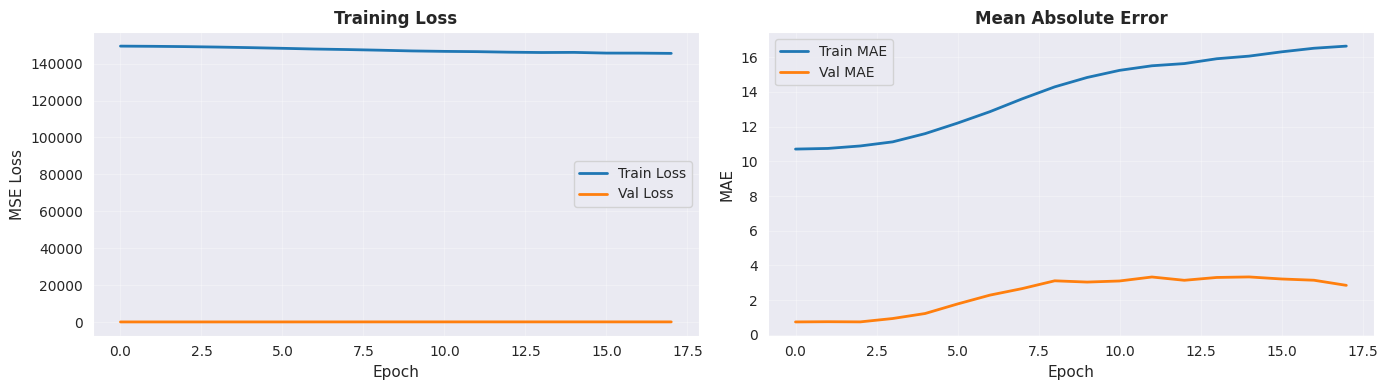

    training_metrics.png

 Creating comprehensive analysis plot...


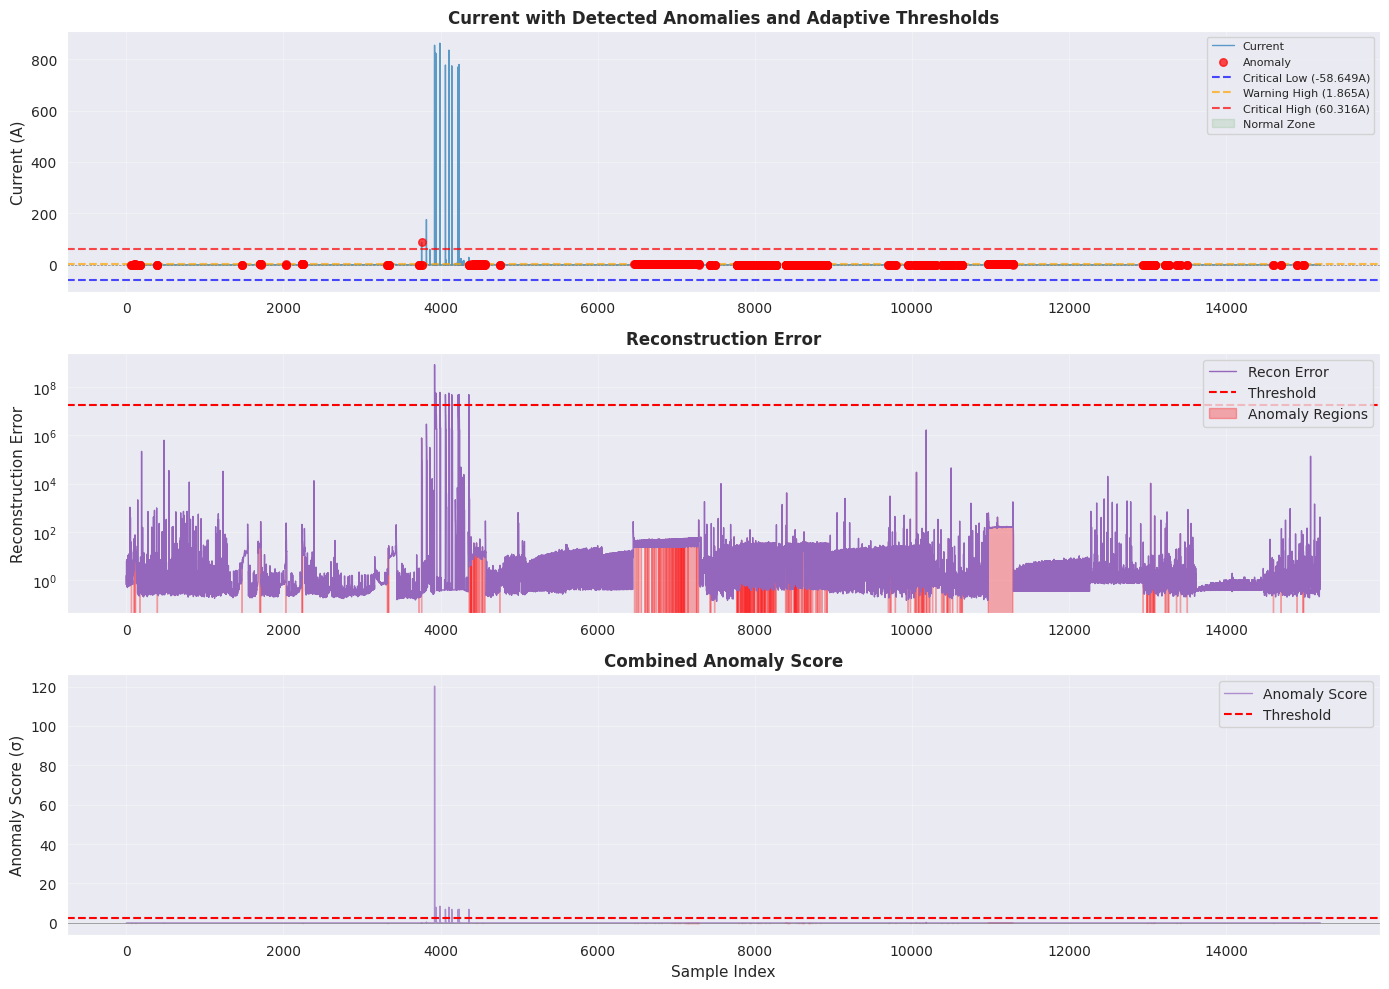

   comprehensive_analysis.png

 Creating per-device recent data visualizations...


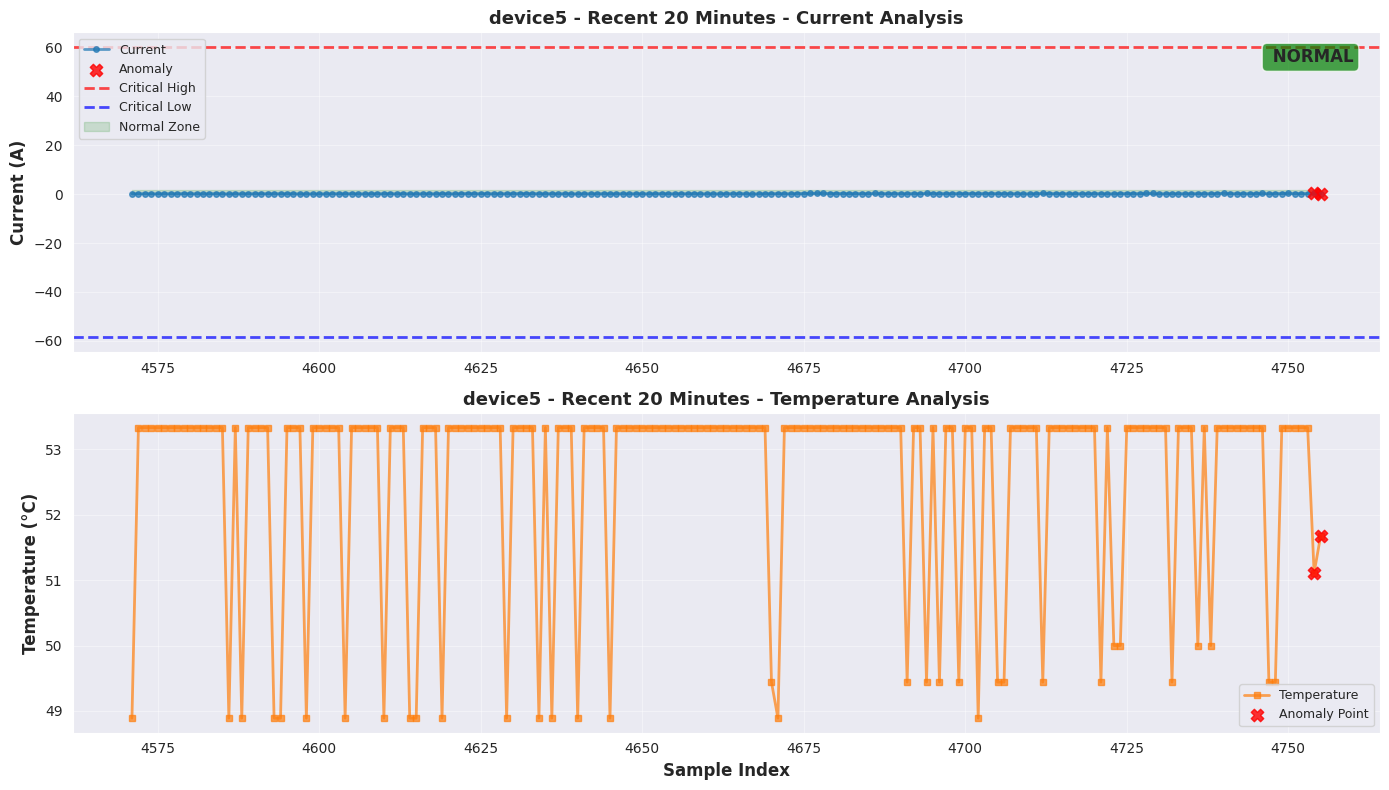

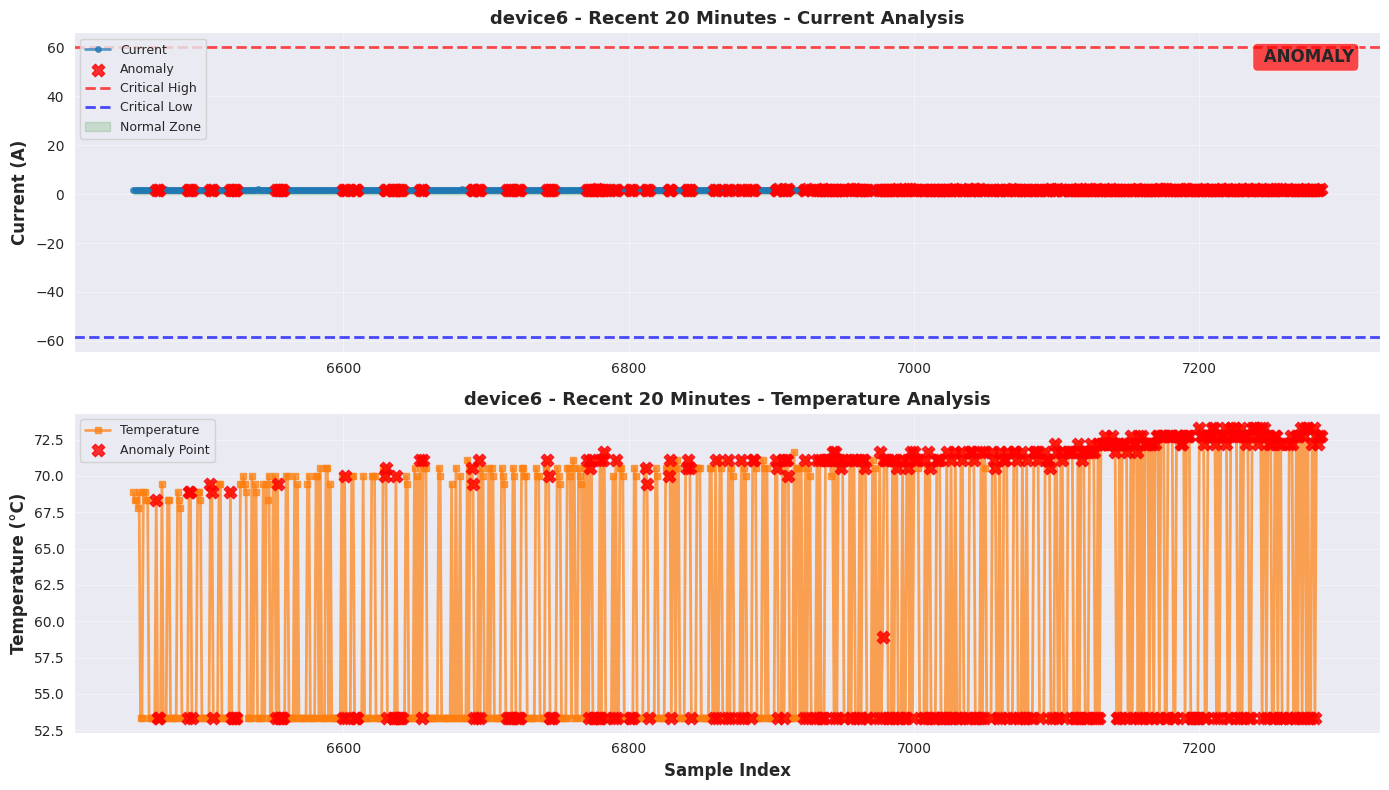

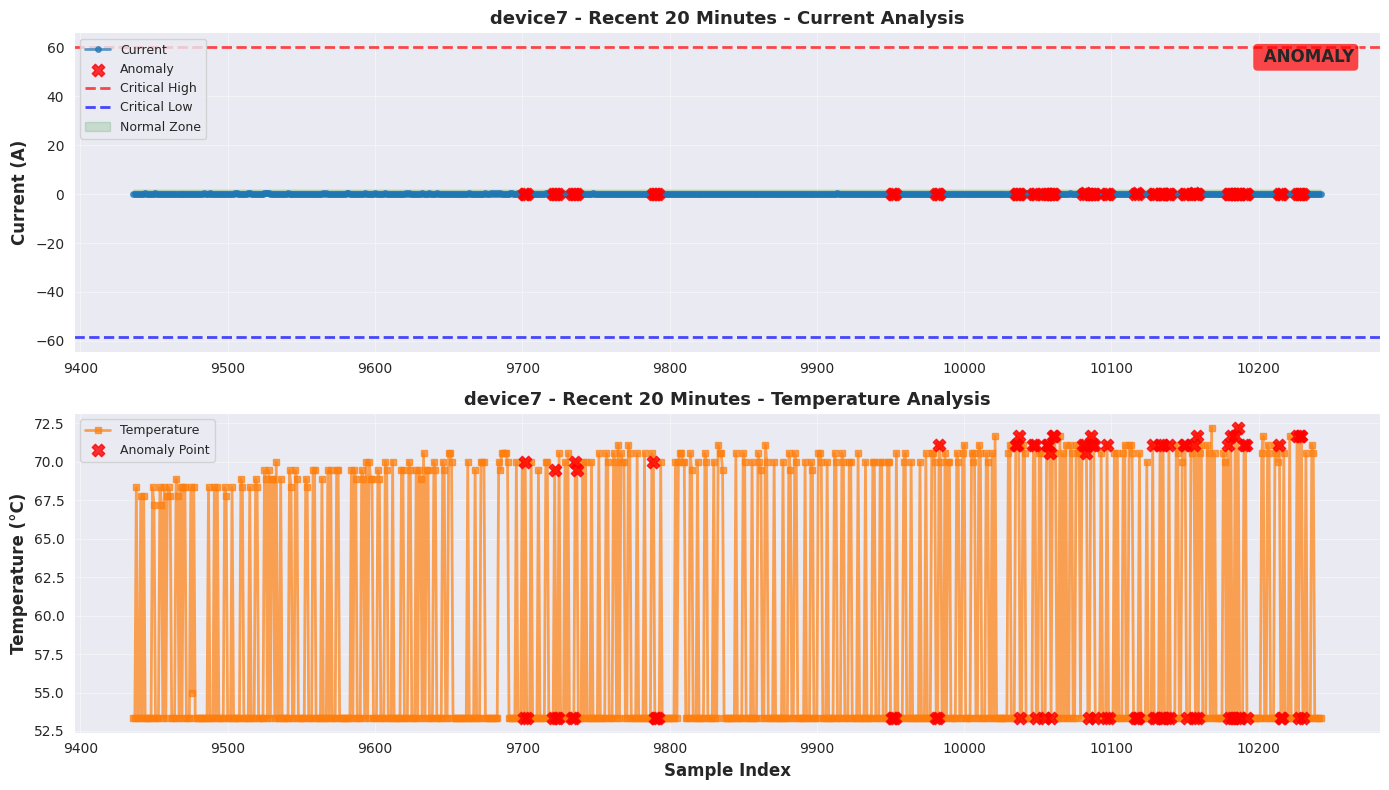

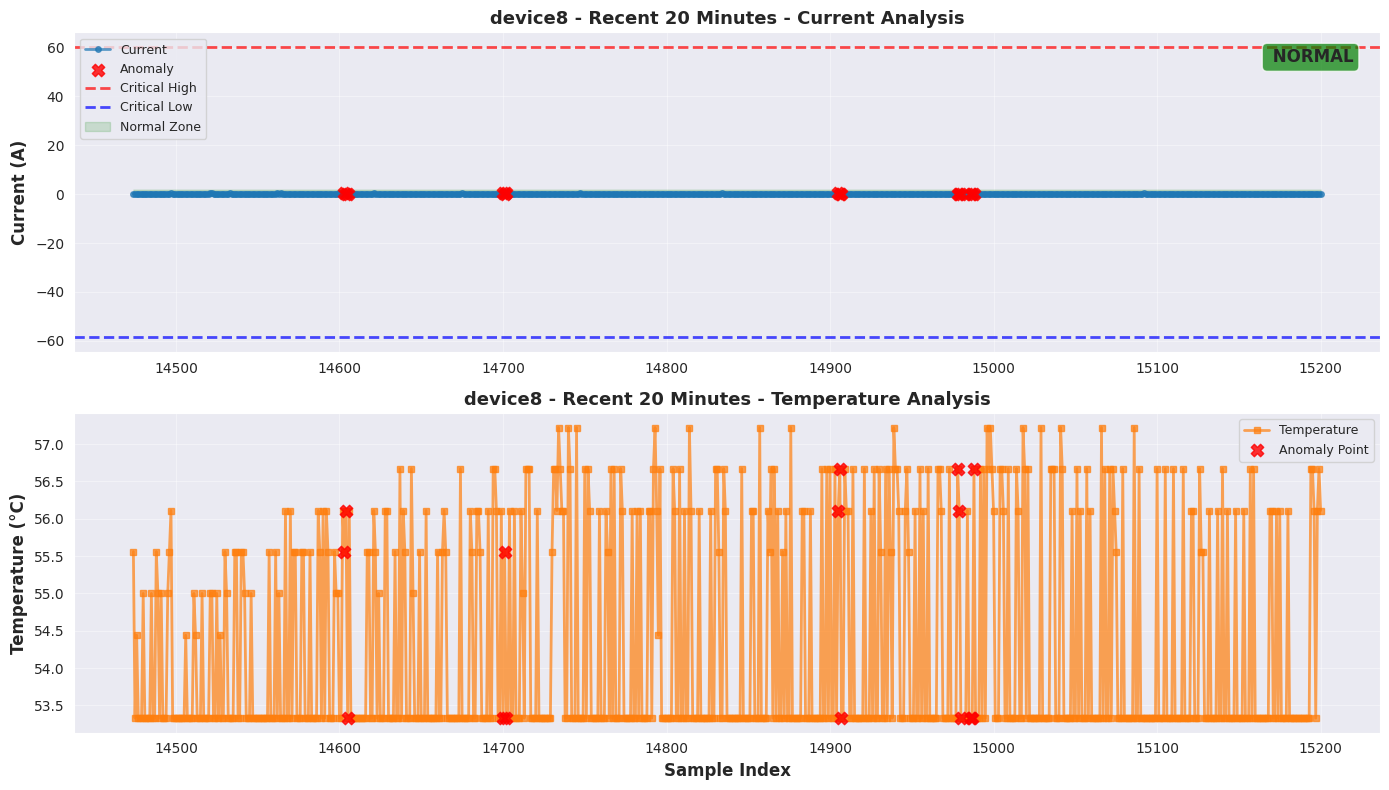

    Per-device recent data plots

 Creating error distribution plot...


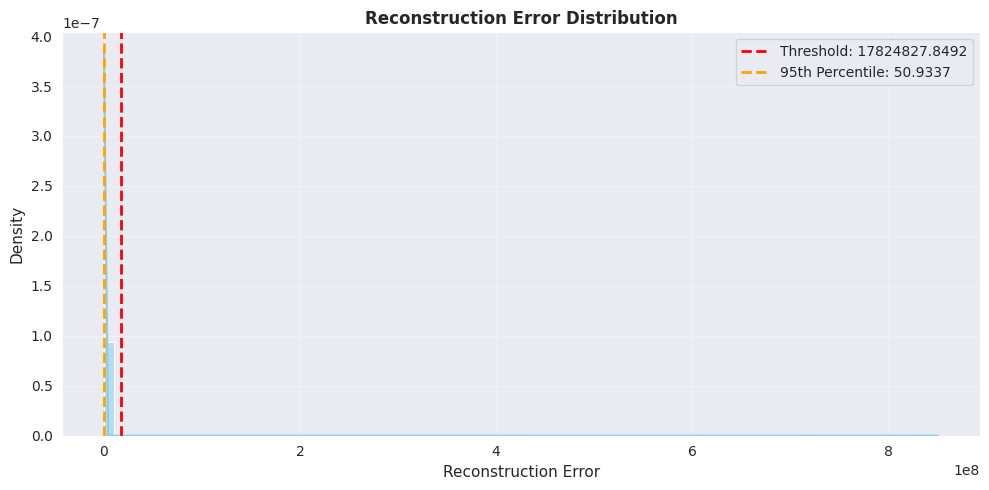

    error_distribution.png

 Creating current distribution plot...


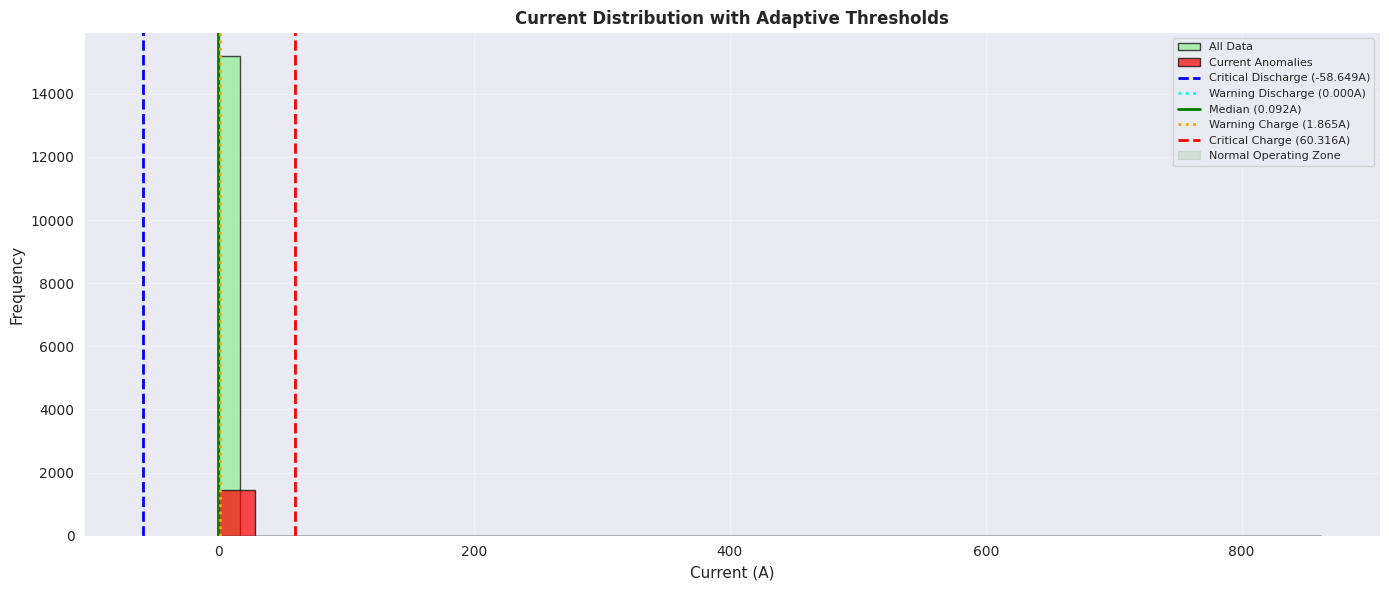

    current_distribution.png

 Creating method comparison heatmap...


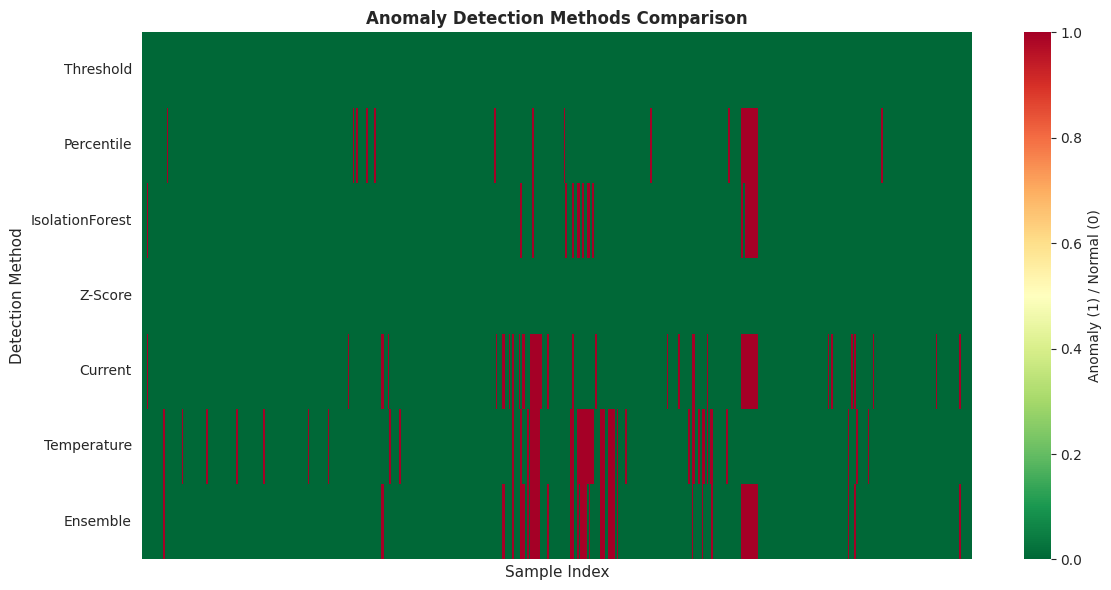

    method_comparison.png

 ALL VISUALIZATIONS COMPLETE


In [ ]:
print("\n Creating training metrics plot...")
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('MSE Loss', fontsize=11)
axes[0].set_title('Training Loss', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('MAE', fontsize=11)
axes[1].set_title('Mean Absolute Error', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'training_metrics.png'), dpi=150, bbox_inches='tight')
plt.show()
print("    training_metrics.png")


print("\n Creating comprehensive analysis plot...")
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Current with anomalies
axes[0].plot(df_out.index, df_out['current'], alpha=0.7, linewidth=1, color='#1f77b4', label='Current')
anomalies = df_out[df_out['anomaly_ensemble_smoothed'] == 1]
axes[0].scatter(anomalies.index, anomalies['current'],
               color='red', s=30, alpha=0.7, label='Anomaly', zorder=5)
axes[0].axhline(y=0, color='gray', linestyle='--', linewidth=0.5)

# Plot adaptive thresholds
axes[0].axhline(y=current_thresholds['lower_critical'], color='blue', linestyle='--',
               label=f"Critical Low ({current_thresholds['lower_critical']:.3f}A)", linewidth=1.5, alpha=0.7)
axes[0].axhline(y=current_thresholds['upper_warning'], color='orange', linestyle='--',
               label=f"Warning High ({current_thresholds['upper_warning']:.3f}A)", linewidth=1.5, alpha=0.7)
axes[0].axhline(y=current_thresholds['upper_critical'], color='red', linestyle='--',
               label=f"Critical High ({current_thresholds['upper_critical']:.3f}A)", linewidth=1.5, alpha=0.7)
axes[0].fill_between(df_out.index, current_thresholds['lower_warning'], current_thresholds['upper_warning'],
                    alpha=0.1, color='green', label='Normal Zone')

axes[0].set_ylabel('Current (A)', fontsize=11)
axes[0].set_title('Current with Detected Anomalies and Adaptive Thresholds', fontsize=12, fontweight='bold')
axes[0].legend(loc='best', fontsize=8)
axes[0].grid(True, alpha=0.3)

# Reconstruction error
axes[1].plot(df_out.index, df_out['recon_error'], color='#9467bd', linewidth=1, label='Recon Error')
axes[1].axhline(y=threshold, color='red', linestyle='--', label='Threshold', linewidth=1.5)
axes[1].fill_between(df_out.index, 0, df_out['recon_error'],
                    where=(df_out['anomaly_ensemble_smoothed'] == 1),
                    color='red', alpha=0.3, label='Anomaly Regions')
axes[1].set_ylabel('Reconstruction Error', fontsize=11)
axes[1].set_title('Reconstruction Error', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

# Anomaly score
axes[2].plot(df_out.index, df_out['anomaly_score'], color='#9467bd', linewidth=1, alpha=0.7, label='Anomaly Score')
axes[2].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
axes[2].axhline(y=THRESHOLD_MULTIPLIER, color='red', linestyle='--', label='Threshold')
axes[2].fill_between(df_out.index, df_out['anomaly_score'].min(), df_out['anomaly_score'],
                    where=(df_out['anomaly_ensemble_smoothed'] == 1),
                    color='red', alpha=0.3)
axes[2].set_xlabel('Sample Index', fontsize=11)
axes[2].set_ylabel('Anomaly Score (σ)', fontsize=11)
axes[2].set_title('Combined Anomaly Score', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'comprehensive_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()
print("   comprehensive_analysis.png")



print("\n Creating per-device recent data visualizations...")
for device in device_names:
    device_data = df_out[df_out['device_id'] == device].copy()
    latest_timestamp = device_data['parsed_datetime'].max()
    cutoff_time = latest_timestamp - timedelta(minutes=RECENT_DATA_WINDOW_MINUTES)
    recent_data = device_data[device_data['parsed_datetime'] >= cutoff_time].copy()

    if len(recent_data) > 0:
        fig, axes = plt.subplots(2, 1, figsize=(14, 8))

        # Recent current data
        axes[0].plot(recent_data.index, recent_data['current'], alpha=0.7, linewidth=2,
                    color='#1f77b4', label='Current', marker='o', markersize=4)
        recent_anom = recent_data[recent_data['anomaly_ensemble_smoothed'] == 1]
        if len(recent_anom) > 0:
            axes[0].scatter(recent_anom.index, recent_anom['current'],
                           color='red', s=80, alpha=0.8, label='Anomaly', zorder=5, marker='X')

        axes[0].axhline(y=current_thresholds['upper_critical'], color='red', linestyle='--',
                       label=f"Critical High", linewidth=2, alpha=0.7)
        axes[0].axhline(y=current_thresholds['lower_critical'], color='blue', linestyle='--',
                       label=f"Critical Low", linewidth=2, alpha=0.7)
        axes[0].fill_between(recent_data.index, current_thresholds['lower_warning'],
                            current_thresholds['upper_warning'],
                            alpha=0.15, color='green', label='Normal Zone')

        # Add verdict badge
        verdict_info = device_verdicts[device]
        if verdict_info['verdict'] == 'YES':
            badge_color = 'red'
            badge_text = ' ANOMALY'
        elif verdict_info['verdict'] == 'NO':
            badge_color = 'green'
            badge_text = ' NORMAL'
        else:
            badge_color = 'orange'
            badge_text = ' INSUFFICIENT DATA'

        axes[0].text(0.98, 0.95, badge_text, transform=axes[0].transAxes,
                    fontsize=12, fontweight='bold', va='top', ha='right',
                    bbox=dict(boxstyle='round', facecolor=badge_color, alpha=0.7))

        axes[0].set_ylabel('Current (A)', fontsize=12, fontweight='bold')
        axes[0].set_title(f'{device} - Recent {RECENT_DATA_WINDOW_MINUTES} Minutes - Current Analysis',
                         fontsize=13, fontweight='bold')
        axes[0].legend(loc='best', fontsize=9)
        axes[0].grid(True, alpha=0.4)

        # Recent temperature data
        axes[1].plot(recent_data.index, recent_data['temperature'], alpha=0.7, linewidth=2,
                    color='#ff7f0e', label='Temperature', marker='s', markersize=4)
        if len(recent_anom) > 0:
            axes[1].scatter(recent_anom.index, recent_anom['temperature'],
                           color='red', s=80, alpha=0.8, label='Anomaly Point', zorder=5, marker='X')

        axes[1].set_xlabel('Sample Index', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Temperature (°C)', fontsize=12, fontweight='bold')
        axes[1].set_title(f'{device} - Recent {RECENT_DATA_WINDOW_MINUTES} Minutes - Temperature Analysis',
                         fontsize=13, fontweight='bold')
        axes[1].legend(loc='best', fontsize=9)
        axes[1].grid(True, alpha=0.4)

        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f'recent_data_{device}.png'), dpi=150, bbox_inches='tight')
        plt.show()

print("    Per-device recent data plots")


print("\n Creating error distribution plot...")
plt.figure(figsize=(10, 5))
sns.histplot(recon_error, bins=80, kde=True, stat='density', color='skyblue')
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2,
           label=f'Threshold: {threshold:.4f}')
plt.axvline(x=percentile_95, color='orange', linestyle='--', linewidth=2,
           label=f'95th Percentile: {percentile_95:.4f}')
plt.xlabel('Reconstruction Error', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.title('Reconstruction Error Distribution', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'error_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()
print("    error_distribution.png")



print("\n Creating current distribution plot...")
plt.figure(figsize=(14, 6))
plt.hist(df_out['current'], bins=50, alpha=0.7, label='All Data', color='lightgreen', edgecolor='black')
plt.hist(df_out[df_out['anomaly_current'] == 1]['current'],
        bins=30, alpha=0.7, label='Current Anomalies', color='red', edgecolor='black')

# Mark thresholds
plt.axvline(x=current_thresholds['lower_critical'], color='blue', linestyle='--',
           label=f"Critical Discharge ({current_thresholds['lower_critical']:.3f}A)", linewidth=2)
plt.axvline(x=current_thresholds['lower_warning'], color='cyan', linestyle=':',
           label=f"Warning Discharge ({current_thresholds['lower_warning']:.3f}A)", linewidth=2)
plt.axvline(x=current_thresholds['median'], color='green', linestyle='-',
           label=f"Median ({current_thresholds['median']:.3f}A)", linewidth=2)
plt.axvline(x=current_thresholds['upper_warning'], color='orange', linestyle=':',
           label=f"Warning Charge ({current_thresholds['upper_warning']:.3f}A)", linewidth=2)
plt.axvline(x=current_thresholds['upper_critical'], color='red', linestyle='--',
           label=f"Critical Charge ({current_thresholds['upper_critical']:.3f}A)", linewidth=2)

# Shade normal zone
plt.axvspan(current_thresholds['lower_warning'], current_thresholds['upper_warning'],
           alpha=0.1, color='green', label='Normal Operating Zone')

plt.xlabel('Current (A)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Current Distribution with Adaptive Thresholds', fontsize=12, fontweight='bold')
plt.legend(fontsize=8, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'current_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()
print("    current_distribution.png")

print("\n Creating method comparison heatmap...")
method_df = pd.DataFrame({
    'Threshold': y_threshold,
    'Percentile': y_percentile,
    'IsolationForest': y_if,
    'Z-Score': y_zscore,
    'Current': current_anomalies,
    'Temperature': temperature_anomalies,
    'Ensemble': y_ensemble_smooth
})

n_samples = min(500, len(method_df))
sample_indices = np.linspace(0, len(method_df)-1, n_samples).astype(int)

plt.figure(figsize=(12, 6))
sns.heatmap(method_df.iloc[sample_indices].T, cmap='RdYlGn_r',
           cbar_kws={'label': 'Anomaly (1) / Normal (0)'},
           yticklabels=True, xticklabels=False)
plt.title('Anomaly Detection Methods Comparison', fontsize=12, fontweight='bold')
plt.xlabel('Sample Index', fontsize=11)
plt.ylabel('Detection Method', fontsize=11)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'method_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()
print("    method_comparison.png")

print("\n ALL VISUALIZATIONS COMPLETE")


# SAMPLE ANOMALIES DISPLAY

In [ ]:
print("\n" + "=" * 80)
print("SAMPLE DETECTED ANOMALIES")
print("=" * 80)

anomalies_df = df_out[df_out['anomaly_ensemble_smoothed'] == 1].copy()
print(f"\nTotal anomalies detected: {len(anomalies_df):,}")

if len(anomalies_df) > 0:
    print("\n" + "─"*110)
    print(f"{'Index':<8} {'Device':<15} {'Current (A)':<12} {'Temp (°C)':<12} {'Datetime':<25} {'Reason'}")
    print("─"*110)

    for idx, row in anomalies_df.head(20).iterrows():
        current_val = f"{row['current']:.4f}"
        temp_val = f"{row['temperature']:.2f}"
        dt_val = str(row['parsed_datetime'])[:19] if pd.notna(row['parsed_datetime']) else "N/A"

        # Determine reason
        reasons = []
        if row['anomaly_current'] == 1 and row['current_anomaly_reason']:
            reasons.append(row['current_anomaly_reason'])
        if row['anomaly_temperature'] == 1 and row['temperature_anomaly_reason']:
            reasons.append(row['temperature_anomaly_reason'])

        if not reasons:
            reasons.append(f"ML: Recon error {row['recon_error']:.4f}")

        reason = "; ".join(reasons)
        if len(reason) > 50:
            reason = reason[:47] + "..."

        print(f"{idx:<8} {row['device_id']:<15} {current_val:<12} {temp_val:<12} {dt_val:<25} {reason}")

    print("─"*110)
else:
  print("\n No anomalies detected in the dataset.")


SAMPLE DETECTED ANOMALIES

Total anomalies detected: 1,622

──────────────────────────────────────────────────────────────────────────────────────────────────────────────
Index    Device          Current (A)  Temp (°C)    Datetime                  Reason
──────────────────────────────────────────────────────────────────────────────────────────────────────────────
64       device5         0.5464       53.33        1970-01-01 00:01:09       Rapid current change: 0.396A/sample
65       device5         0.3094       53.33        1970-01-01 00:01:10       Rapid current change: 0.237A/sample
66       device5         0.4644       53.33        1970-01-01 00:01:11       Rapid current change: 0.155A/sample
97       device5         0.6974       48.89        1970-01-01 00:01:42       Low temp: 48.89°C
98       device5         1.4544       48.89        1970-01-01 00:01:43       Rapid current change: 0.757A/sample; Low temp: ...
99       device5         1.2424       48.89        1970-01-01 00:01:44 

# FINAL SUMMARY REPORT

In [ ]:
print("\n" + "=" * 80)
print("DEVICE VERDICTS SUMMARY")
print("=" * 80)

print(f"\n{'Device':<15} {'Verdict':<8} {'Status':<25} {'Samples':<10} {'Anomalies':<12} {'Rate':<10}")
print("─"*90)

for device, verdict_info in device_verdicts.items():
    verdict_display = verdict_info['verdict']
    if verdict_display == "YES":
        icon = ""
    elif verdict_display == "NO":
        icon = ""
    else:
        icon = ""

    status = verdict_info['message']
    samples = verdict_info['samples']
    anomalies = verdict_info['anomaly_count']
    rate = f"{verdict_info['anomaly_rate']:.2f}%"

    print(f"{device:<15} {icon} {verdict_display:<5} {status:<25} {samples:<10} {anomalies:<12} {rate:<10}")

print("─"*90)

# Overall summary
yes_count = sum(1 for v in device_verdicts.values() if v['verdict'] == 'YES')
no_count = sum(1 for v in device_verdicts.values() if v['verdict'] == 'NO')
insufficient_count = sum(1 for v in device_verdicts.values() if v['verdict'] == 'INSUFFICIENT_DATA')

print(f"\n Overall Summary:")
print(f"   Total Devices: {len(device_verdicts)}")
print(f"    Anomaly Detected: {yes_count} device(s)")
print(f"    Normal Operation: {no_count} device(s)")
print(f"    Insufficient Data: {insufficient_count} device(s)")

if yes_count > 0:
    print(f"\n  ACTION REQUIRED: {yes_count} device(s) showing anomalies!")
    print(f"   Devices requiring attention:")
    for device, verdict_info in device_verdicts.items():
        if verdict_info['verdict'] == 'YES':
            print(f"     • {device} - {verdict_info['anomaly_count']} anomalies ({verdict_info['anomaly_rate']:.2f}%)")
            if verdict_info['critical_events'] > 0:
                print(f"       - Critical events: {verdict_info['critical_events']}")
            if verdict_info['high_severity_events'] > 0:
                print(f"       - High severity events: {verdict_info['high_severity_events']}")
else:
    print(f"\n All devices operating normally in the last {RECENT_DATA_WINDOW_MINUTES} minutes")



DEVICE VERDICTS SUMMARY

Device          Verdict  Status                    Samples    Anomalies    Rate      
──────────────────────────────────────────────────────────────────────────────────────────
device5          NO    NORMAL OPERATION          185        2            1.08%     
device6          YES   ANOMALY DETECTED          833        424          50.90%    
device7          YES   ANOMALY DETECTED          807        86           10.66%    
device8          NO    NORMAL OPERATION          727        15           2.06%     
──────────────────────────────────────────────────────────────────────────────────────────

 Overall Summary:
   Total Devices: 4
    Anomaly Detected: 2 device(s)
    Normal Operation: 2 device(s)
    Insufficient Data: 0 device(s)

  ACTION REQUIRED: 2 device(s) showing anomalies!
   Devices requiring attention:
     • device6 - 424 anomalies (50.90%)
       - Critical events: 104
       - High severity events: 394
     • device7 - 86 anomalies (10.66%)
 

# FINAL REPORT

In [ ]:
print("\n" + "=" * 80)
print("BATTERY ANOMALY DETECTION - COMPLETE")
print("=" * 80)

print(f"\n FINAL SUMMARY:")
print(f"{'='*80}")

print(f"\n Data Source: API ({len(device_names)} devices)")
for device in device_names:
    device_count = (df_out['device_id'] == device).sum()
    print(f"    {device}: {device_count:,} samples")

print(f"\n Current Analysis:")
print(f"   Data Range: [{df['current'].min():.4f}, {df['current'].max():.4f}] A")
print(f"   Normal Range: [{current_thresholds['Q1']:.4f}, {current_thresholds['Q3']:.4f}] A")
print(f"   Zero values: {(df['current'] == 0).sum():,} ({100*(df['current'] == 0).mean():.2f}%)")
print(f"   Adaptive Thresholds:")
print(f"      Unusually Low: <{current_thresholds['lower_critical']:.4f} A")
print(f"      Warning Charge: >{current_thresholds['upper_warning']:.4f} A")
print(f"      Critical Charge: >{current_thresholds['upper_critical']:.4f} A")

print(f"\n  Temperature Analysis:")
print(f"   Data Range: [{df['temperature'].min():.2f}, {df['temperature'].max():.2f}] °C")
print(f"   Normal Range: [{temperature_thresholds['Q1']:.2f}, {temperature_thresholds['Q3']:.2f}] °C")
print(f"   Adaptive Thresholds:")
print(f"      Critical Low: <{temperature_thresholds['lower_critical']:.2f} °C")
print(f"      Warning Low: <{temperature_thresholds['lower_warning']:.2f} °C")
print(f"      Warning High: >{temperature_thresholds['upper_warning']:.2f} °C")
print(f"      Critical High: >{temperature_thresholds['upper_critical']:.2f} °C")

print(f"\n Overall Results:")
print(f"   Total Samples: {len(df_out):,}")
print(f"   Total Anomalies: {y_ensemble_smooth.sum():,} ({100*y_ensemble_smooth.mean():.2f}%)")
print(f"   Critical Events: {critical_count:,}")
print(f"   High Severity: {high_count:,}")

print(f"\n Recent {RECENT_DATA_WINDOW_MINUTES} Minutes Analysis (Per Device):")
for device in device_names:
    verdict_info = device_verdicts[device]
    if verdict_info['verdict'] == 'YES':
        icon = ""
    elif verdict_info['verdict'] == 'NO':
        icon = ""
    else:
        icon = ""

    print(f"   {icon} {device}: {verdict_info['verdict']} - {verdict_info['message']}")
    if verdict_info['verdict'] != 'INSUFFICIENT_DATA':
        print(f"      Samples: {verdict_info['samples']:,}, Anomalies: {verdict_info['anomaly_count']:,} ({verdict_info['anomaly_rate']:.2f}%)")

print(f"\n{'='*80}")
print(f" Output Directory: {OUT_DIR}")
print(f" All results saved successfully!")
print(f" All visualizations created!")
print(f" Model trained and saved!")



BATTERY ANOMALY DETECTION - COMPLETE

 FINAL SUMMARY:

 Data Source: API (4 devices)
    device5: 4,756 samples
    device6: 2,530 samples
    device7: 2,957 samples
    device8: 4,958 samples

 Current Analysis:
   Data Range: [0.0000, 862.1401] A
   Normal Range: [0.0000, 0.1953] A
   Zero values: 4,235 (27.86%)
   Adaptive Thresholds:
      Unusually Low: <-58.6488 A
      Warning Charge: >1.8649 A
      Critical Charge: >60.3164 A

  Temperature Analysis:
   Data Range: [48.89, 73.33] °C
   Normal Range: [53.33, 53.33] °C
   Adaptive Thresholds:
      Critical Low: <39.13 °C
      Warning Low: <53.33 °C
      Warning High: >70.56 °C
      Critical High: >72.18 °C

 Overall Results:
   Total Samples: 15,201
   Total Anomalies: 1,622 (10.67%)
   Critical Events: 446
   High Severity: 857

 Recent 20 Minutes Analysis (Per Device):
    device5: NO - NORMAL OPERATION
      Samples: 185, Anomalies: 2 (1.08%)
    device6: YES - ANOMALY DETECTED
      Samples: 833, Anomalies: 424 (50.90%)